# Introduction to Reinforcement Learning Course - Assignment 2
Group Members: Iulia-Elena Teodorescu, Adnan Al Medawer, Konstantinos Tantoulas, Likhith Bedara Agrahara Venkateshamurthy

# Import libraries

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import time

# Define model

In [19]:
# Define model
class DQN(nn.Module):
    def __init__(self, lr,state_size, n_actions, seed, fc1_units=256, fc2_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            n_actions (int): Dimension of each action
            seed (int): Random seed
        """
        super().__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, n_actions)
        
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x) 
        return actions


# Define Experience Replay Buffer

In [20]:
class ReplayBuffer:

    def __init__(self, n_actions, buffer_size, batch_size, seed):

        self.n_actions = n_actions
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        self.memory.append((state, action, reward, next_state, done))

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        # Convert to torch tensors
        states = torch.tensor(states, dtype=torch.float32).to(device)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
        dones = torch.tensor(dones, dtype=torch.float32).to(device)
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)    

In [21]:
BUFFER_SIZE = 100000  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the target network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
class Agent():

    def __init__(self, state_size, n_actions, seed):

        self.state_size = state_size
        self.n_actions = n_actions
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_policy = DQN(LR, state_size, n_actions, seed)#.to(device)
        self.qnetwork_target = DQN(LR, state_size, n_actions, seed)#.to(device)

        # Replay memory
        self.memory = ReplayBuffer(n_actions, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        """Store experience and perform learning."""
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0 and len(self.memory) > BATCH_SIZE:
            self.learn(self.memory.sample(), GAMMA)


    def select_action(self, state, eps=0.):
        """Choose an action based on epsilon-greedy policy."""
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            action_values = self.qnetwork_policy(state)
        # Epsilon-greedy action selection
        if np.random.rand() > eps:
            action = torch.argmax(action_values).item()
        else:
            action = np.random.randint(self.n_actions)
        return action

                   
    def learn(self, experiences, gamma):
        """Update Q-network parameters using a batch of experience tuples."""
        states, actions, rewards, next_states, dones = experiences

        # Compute target Q values for the current state
        with torch.no_grad():
            Q_targets_next = self.qnetwork_target(next_states).max(1, keepdim=True)[0]
            Q_targets = rewards + gamma * Q_targets_next * (1 - dones)
        
        # Compute the predicted Q values for the chosen actions
        Q_expected = self.qnetwork_policy(states).gather(1, actions)

        # Update policy Q-network
        loss = F.mse_loss(Q_expected, Q_targets)
        self.qnetwork_policy.optimizer.zero_grad()
        loss.backward()
        self.qnetwork_policy.optimizer.step()

        # Update target Q-network
        self.update_network(self.qnetwork_policy, self.qnetwork_target, TAU)

    def update_network(self, local_model, target_model, tau):
        """ Update target model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

## Train the Agent with DQN

In [23]:
def train(agent, env, n_episodes=4000, max_t=1000, eps=1.0, eps_min=0.01, eps_decay=0.995):
    """Train the agent using Deep Q-Learning."""
    rewards = []                          # List to store total rewards for each episode
    epsilon_values = []                   # List to store epsilon values for each episode
    rewards_window = deque(maxlen=100)    # Last 100 rewards for average reward
    for i_episode in range(n_episodes):
        state, info = env.reset()         # Reset environment and get initial state
        score = 0
        for t in range(max_t):           
            action = agent.select_action(state, eps)  # Get action based on epsilon-greedy policy
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.step(state, action, reward, next_state, done)  # Store experience and learn
            state = next_state
            score += reward
            if done:
                break
        
        # Log the total reward and epsilon for this episode
        rewards.append(score)
        epsilon_values.append(eps)
        rewards_window.append(score)  # Add current episode score to the window
        
        if eps > eps_min:                 # Decay epsilon
            eps -= eps_decay
        else:
            eps = eps_min
        
        # Print the episode information
        print(f'\rEpisode {i_episode+1}/{n_episodes}\t Total Reward: {score:.2f}', end="")
        if i_episode % 100 == 0:
            print(f'\rEpisode {i_episode+1}/{n_episodes}\tAverage Reward: {np.mean(rewards_window):.2f}')
        if np.mean(rewards_window) >= 200.0:  # Check if the environment is solved
            print(f'\nEnvironment solved in {i_episode+1-100} episodes!\tAverage Reward: {np.mean(rewards_window):.2f}')
            torch.save(agent.qnetwork_policy.state_dict(), 'checkpoint_lunar.pth') 
            break
    
    return rewards, epsilon_values


## Evaluate the Agent

In [24]:
def test(agent, env, n_episodes=100, max_t=1000, eps=0.):
    """Test the agent after training."""
    rewards = []  # List to store total rewards for each episode
    for i_episode in range(1, n_episodes + 1):
        state, info = env.reset()  # Reset environment and get initial state
        score = 0
        for t in range(max_t):     # Loop over each time step in the episode
            action = agent.select_action(state, eps)  # Get action based on epsilon-greedy policy
            next_state, reward, done, info, _ = env.step(action)  # Step in the environment
            state = next_state
            score += reward
            if done:
                break
        
        # Log the total reward for this episode
        rewards.append(score)
        print(f'\rTest Episode {i_episode+1}/{n_episodes}\tTotal Reward: {score:.2f}', end="")
        if i_episode % 10 == 0:
            print(f'\rTest Episode {i_episode+1}/{n_episodes}\tTotal Reward: {score:.2f}')
    
    return rewards

# Instantiate the Environment and Agent

Initialize the environment in the code cell below.

Results after having hidden layers with 64 neurons

C:\Users\Julyyy\AppData\Local\Temp\ipykernel_13944\3324246063.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  states = torch.tensor(states, dtype=torch.float32).to(device)
C:\Users\Julyyy\AppData\Local\Temp\ipykernel_13944\1001400498.py:52: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(Q_expected, Q_targets)


Episode 1/2000	Average Reward: -125.52
Episode 101/2000	Average Reward: -469.01
Episode 201/2000	Average Reward: -487.63
Episode 301/2000	Average Reward: -613.83
Episode 401/2000	Average Reward: -550.43
Episode 501/2000	Average Reward: -482.24
Episode 601/2000	Average Reward: -603.33
Episode 701/2000	Average Reward: -622.43
Episode 801/2000	Average Reward: -716.53
Episode 901/2000	Average Reward: -778.09
Episode 1001/2000	Average Reward: -746.23
Episode 1101/2000	Average Reward: -704.57
Episode 1201/2000	Average Reward: -582.72
Episode 1301/2000	Average Reward: -529.01
Episode 1401/2000	Average Reward: -519.41
Episode 1501/2000	Average Reward: -500.37
Episode 1601/2000	Average Reward: -518.20
Episode 1701/2000	Average Reward: -426.07
Episode 1801/2000	Average Reward: -410.52
Episode 1901/2000	Average Reward: -373.74
Test Episode 11/100	Total Reward: -153.82
Test Episode 21/100	Total Reward: -196.89
Test Episode 31/100	Total Reward: -117.30
Test Episode 41/100	Total Reward: -133.77
Test

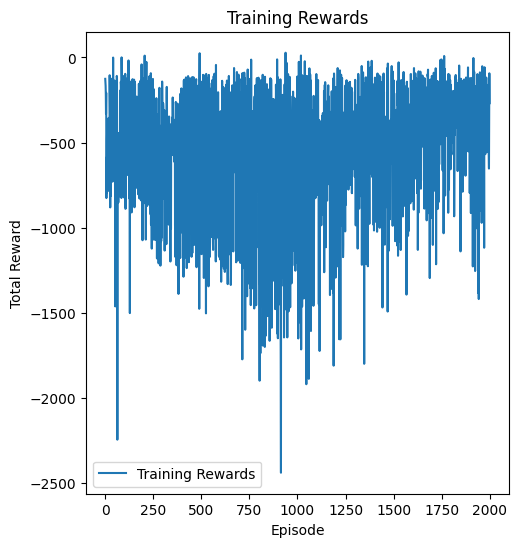

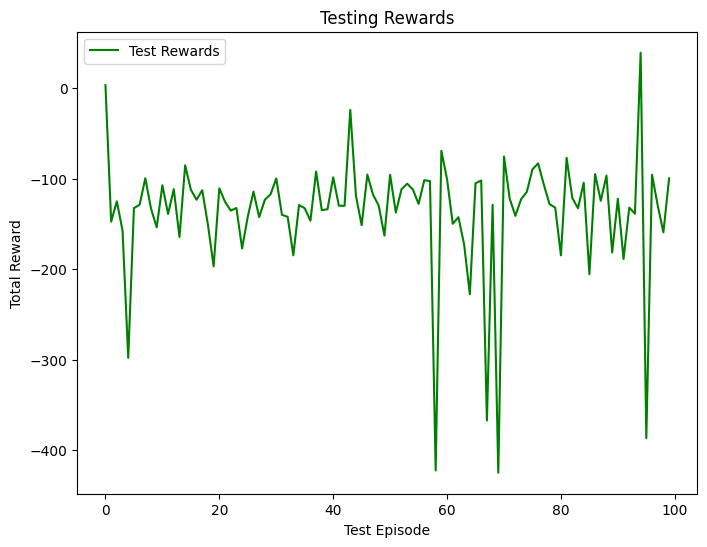

In [11]:
# Initialize environment and agent
env = gym.make('LunarLander-v3', render_mode='human')
agent = Agent(state_size=env.observation_space.shape[0], n_actions=env.action_space.n, seed=0)

# Train the agent and log the total rewards and epsilon
train_rewards, epsilon_values = train(agent, env, n_episodes=2000, eps=1.0, eps_min=0.01, eps_decay=0.995)

# Test the agent after training
test_rewards = test(agent, env, n_episodes=100, max_t=1000, eps=0.)

# Plot the training rewards
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(train_rewards)), train_rewards, label='Training Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Rewards')
plt.legend()

# Plot the testing rewards
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(test_rewards)), test_rewards, label='Test Rewards', color='green')
plt.xlabel('Test Episode')
plt.ylabel('Total Reward')
plt.title('Testing Rewards')
plt.legend()
plt.show()

env.close()  # Close the environment after testing


Results after having hidden layers with 128 neurons

C:\Users\Julyyy\AppData\Local\Temp\ipykernel_13944\1001400498.py:52: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(Q_expected, Q_targets)


Episode 1/2000	Average Reward: -85.94
Episode 101/2000	Average Reward: -462.74
Episode 201/2000	Average Reward: -483.36
Episode 301/2000	Average Reward: -432.30
Episode 401/2000	Average Reward: -429.16
Episode 501/2000	Average Reward: -485.68
Episode 601/2000	Average Reward: -586.48
Episode 701/2000	Average Reward: -491.28
Episode 801/2000	Average Reward: -526.41
Episode 901/2000	Average Reward: -465.27
Episode 1001/2000	Average Reward: -485.15
Episode 1101/2000	Average Reward: -416.93
Episode 1201/2000	Average Reward: -437.79
Episode 1301/2000	Average Reward: -416.48
Episode 1401/2000	Average Reward: -378.08
Episode 1501/2000	Average Reward: -337.79
Episode 1601/2000	Average Reward: -354.73
Episode 1701/2000	Average Reward: -340.97
Episode 1801/2000	Average Reward: -303.53
Episode 1901/2000	Average Reward: -324.78
Test Episode 11/100	Total Reward: -82.190
Test Episode 21/100	Total Reward: -301.62
Test Episode 31/100	Total Reward: -61.788
Test Episode 41/100	Total Reward: -361.08
Test 

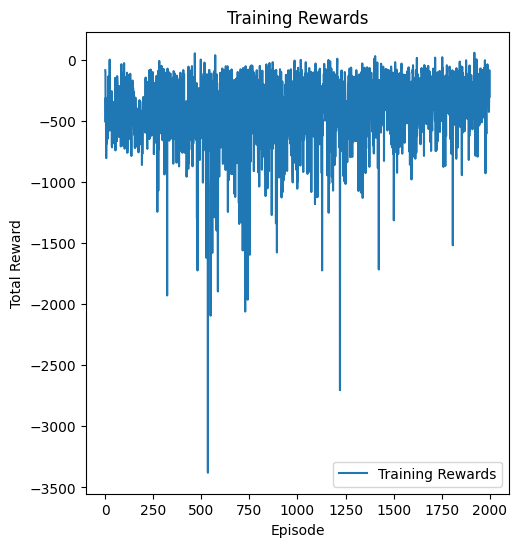

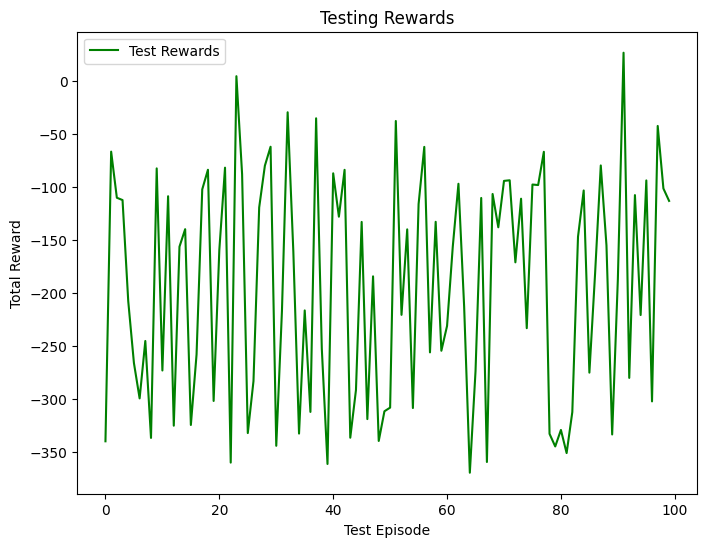

In [18]:
# Initialize environment and agent
env = gym.make('LunarLander-v3', render_mode='human')
agent = Agent(state_size=env.observation_space.shape[0], n_actions=env.action_space.n, seed=0)

# Train the agent and log the total rewards and epsilon
train_rewards, epsilon_values = train(agent, env, n_episodes=2000, eps=1.0, eps_min=0.01, eps_decay=0.995)

# Test the agent after training
test_rewards = test(agent, env, n_episodes=100, max_t=1000, eps=0.)

# Plot the training rewards
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(train_rewards)), train_rewards, label='Training Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Rewards')
plt.legend()

# Plot the testing rewards
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(test_rewards)), test_rewards, label='Test Rewards', color='green')
plt.xlabel('Test Episode')
plt.ylabel('Total Reward')
plt.title('Testing Rewards')
plt.legend()
plt.show()

env.close()  # Close the environment after testing


Results after having hidden layers with 256 neurons and 4000 episodes

C:\Users\Julyyy\AppData\Local\Temp\ipykernel_13944\1001400498.py:52: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(Q_expected, Q_targets)


Episode 1/4000	Average Reward: -112.75
Episode 101/4000	Average Reward: -316.36
Episode 201/4000	Average Reward: -354.32
Episode 301/4000	Average Reward: -319.89
Episode 401/4000	Average Reward: -395.55
Episode 501/4000	Average Reward: -362.02
Episode 601/4000	Average Reward: -371.69
Episode 701/4000	Average Reward: -390.36
Episode 801/4000	Average Reward: -336.91
Episode 901/4000	Average Reward: -360.36
Episode 1001/4000	Average Reward: -353.27
Episode 1101/4000	Average Reward: -356.97
Episode 1201/4000	Average Reward: -313.06
Episode 1301/4000	Average Reward: -287.91
Episode 1401/4000	Average Reward: -289.47
Episode 1501/4000	Average Reward: -220.21
Episode 1601/4000	Average Reward: -250.38
Episode 1701/4000	Average Reward: -200.30
Episode 1801/4000	Average Reward: -225.47
Episode 1901/4000	Average Reward: -185.51
Episode 2001/4000	Average Reward: -212.56
Episode 2101/4000	Average Reward: -196.57
Episode 2201/4000	Average Reward: -209.95
Episode 2301/4000	Average Reward: -208.04
Epis

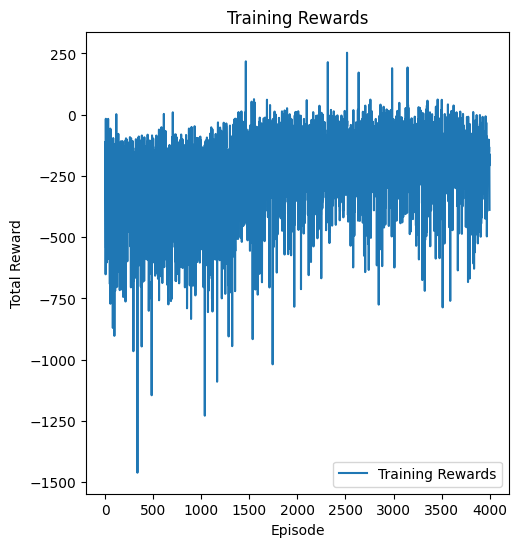

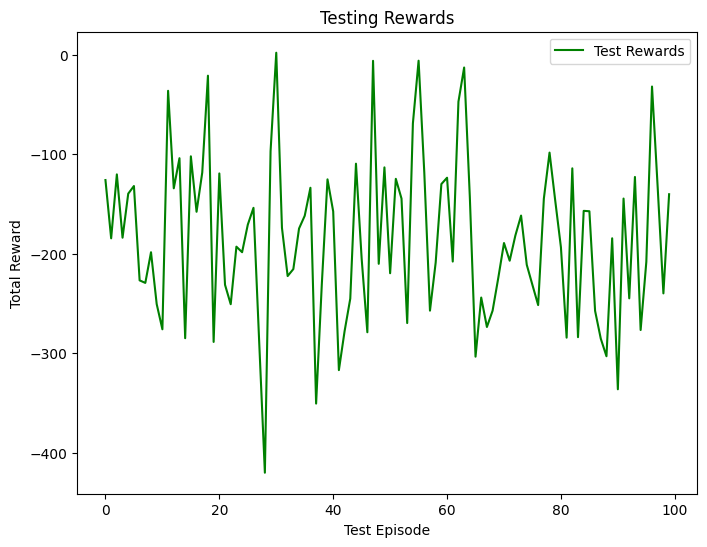

In [26]:
# Initialize environment and agent
env = gym.make('LunarLander-v3', render_mode='human')
agent = Agent(state_size=env.observation_space.shape[0], n_actions=env.action_space.n, seed=0)

# Train the agent and log the total rewards and epsilon
train_rewards, epsilon_values = train(agent, env, n_episodes=4000, eps=1.0, eps_min=0.01, eps_decay=0.995)

# Test the agent after training
test_rewards = test(agent, env, n_episodes=100, max_t=1000, eps=0.)

# Plot the training rewards
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(train_rewards)), train_rewards, label='Training Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Rewards')
plt.legend()

# Plot the testing rewards
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(test_rewards)), test_rewards, label='Test Rewards', color='green')
plt.xlabel('Test Episode')
plt.ylabel('Total Reward')
plt.title('Testing Rewards')
plt.legend()
plt.show()

env.close()  # Close the environment after testing
